# PyTorch

## { parte 2 - tentando fazer algo mais pratico }

In [1]:
%pylab inline

import torch
from torch import optim
from torch import autograd, nn
from torch.nn import functional as F

from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(15, 8)
style.use("fivethirtyeight")

### A rede neural

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.in_to_h1 = nn.Linear(input_size, hidden_size)
        self.h1_to_h2 = nn.Linear(hidden_size, hidden_size)
        self.h2_to_out = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = F.relu(self.in_to_h1(x))
        x = F.relu(self.h1_to_h2(x))
        x = self.h2_to_out(x)
        return x

### Lendo os dados

In [4]:
trans = transforms.Compose([transforms.ToTensor(), 
                           transforms.Lambda(lambda x: x.view(-1, 28*28) )
                           ])

data = torchvision.datasets.MNIST("datasets/mnist/", transform=trans)

batch_size = 30
train = DataLoader(dataset=data, batch_size=batch_size*10, shuffle=True)
test = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

In [5]:
t = iter(test).next()

In [6]:
t[0].shape, t[1].shape

(torch.Size([30, 1, 784]), torch.Size([30]))

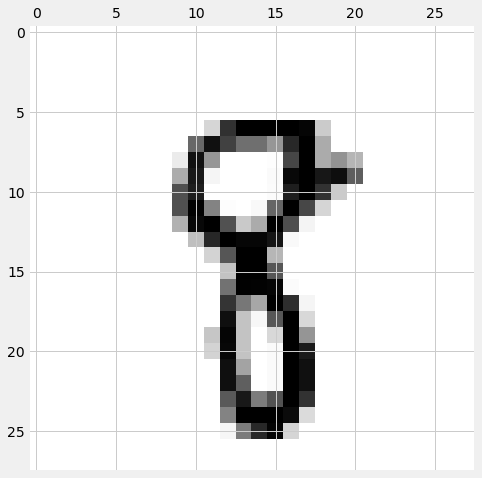

In [14]:
matshow(t[0][3].view(28, 28).detach().numpy(), cmap=cm.gray_r)

### Treinamento e outras coisas

In [8]:
rna = Model(28*28, 128, 10)
rna

Model(
  (in_to_h1): Linear(in_features=784, out_features=128, bias=True)
  (h1_to_h2): Linear(in_features=128, out_features=128, bias=True)
  (h2_to_out): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
rna(t[0][3])# .argmax()

tensor([[-3.6562, -0.2822, -2.0400,  0.8850, -1.7166,  0.4896, -4.3694, -0.8155,
          2.5690,  0.5601]], grad_fn=<ThAddmmBackward>)

In [10]:
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rna.parameters(), lr=learning_rate)

In [11]:
epochs = 3

test_dataloader = iter(test)
test_data, test_target = next(test_dataloader)

losses = []
percs = []
for i in tqdm(range(epochs)):
    for data, target in tqdm(train):
        out = rna(data.view(-1, 28*28))
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
    
        res = np.array([i.argmax().item() for i in rna(test_data.view(-1, 28*28))])
        c = 0
        for i in res - test_target.detach().numpy():
            if i == 0:
                c+=1
        perc = c/len(res)
        percs.append(perc)
        
        test_data, test_target = next(test_dataloader)

Text(0.5,1,'loss final: 0.30789801478385925 - percentual final de acerto: 0.9666666666666667')

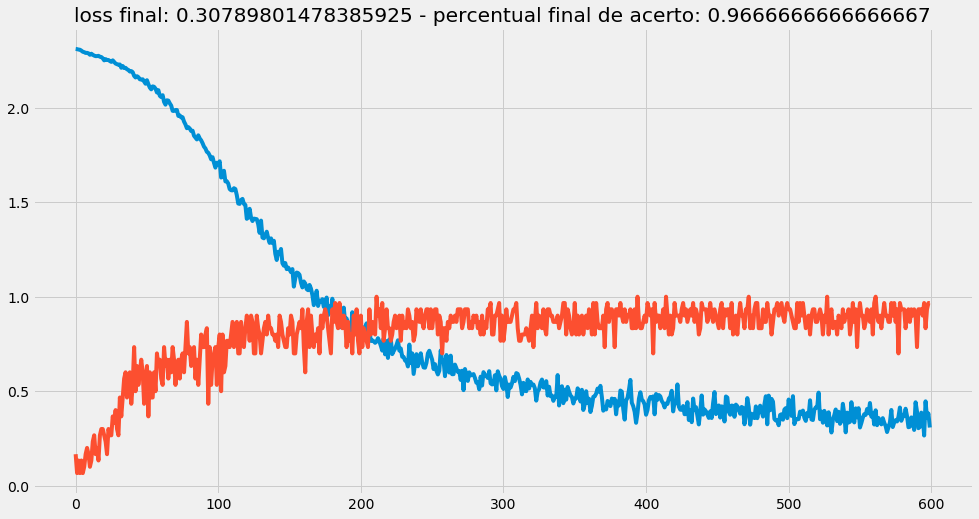

In [12]:
ax = subplot()
ax.plot(losses)
ax.plot(percs)
ax.set_title(f"loss final: {losses[-1]} - percentual final de acerto: {percs[-1]}")

tensor de saída:  tensor([[ 2.4209, -7.3938,  0.5879, -1.8449,  0.0472,  1.1604,  4.2075, -4.7067,
         -1.7270, -3.0181]], grad_fn=<SelectBackward>)


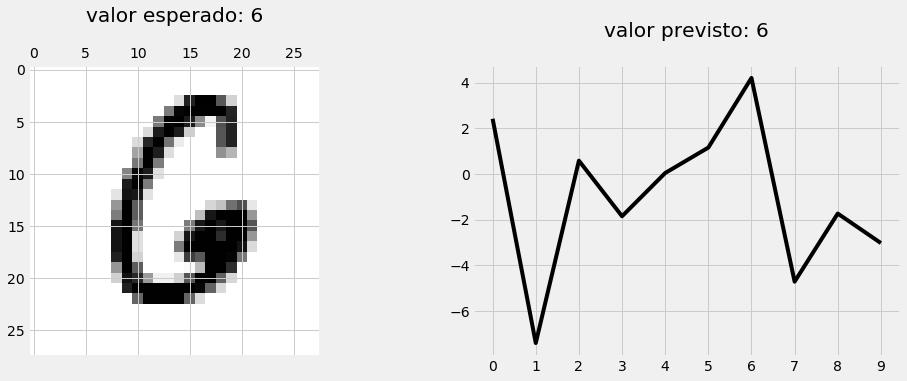

In [13]:
index = 2

test_data, test_target = iter(test).next()
out=rna(test_data)


print("tensor de saída: ", out[index])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.matshow(
    test_data[index].view(28,28).detach().numpy(),
    cmap=plt.cm.gray_r)

ax1.set_title(f"valor esperado: {test_target[index]}\n")

ax2.plot(
    out[index].squeeze().detach().numpy(),
    color="k")

ax2.grid(True)
ax2.set_title(f"valor previsto: {out[index].argmax()}\n")
plt.setp(ax2, xticks=list(range(10)));